In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from tqdm.notebook import tqdm

import numpy as np
import os
import copy
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans

# for unzipping
import zipfile

# this makes pyplot in interactive mode
plt.ion()

In [ ]:
!mkdir -p /content/cityscape
%cd /content/cityscape
!gdown https://drive.google.com/uc?id=1-wW9hhaCCjONO_1HZSFR0gpnozYmmDFw

/content/cityscape
Downloading...
From (original): https://drive.google.com/uc?id=1-wW9hhaCCjONO_1HZSFR0gpnozYmmDFw
From (redirected): https://drive.google.com/uc?id=1-wW9hhaCCjONO_1HZSFR0gpnozYmmDFw&confirm=t&uuid=97880239-86ac-4ac8-81cc-8e47b83280f1
To: /content/cityscape/archive.zip
100% 211M/211M [00:02<00:00, 91.6MB/s]


In [ ]:
!unzip archive.zip

Archive:  archive.zip
replace cityscapes_data/cityscapes_data/train/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cityscapes_data/cityscapes_data/train/10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
%cd /content

/content


In [ ]:
# train directory
train_dir = '/content/cityscape/cityscapes_data/train'

# validation directory
val_dir = '/content/cityscape/cityscapes_data/val'

print(f'Train directory {train_dir}\nValidation directory {val_dir}\n')

# train, validation samples list
train_samples, validation_samples = os.listdir(train_dir), os.listdir(val_dir)
print(f'Total Training image pairs {len(train_samples)}\nTotal Validation image pairs {len(validation_samples)}\n')

print(f'Sample image shape {np.array(Image.open(os.path.join(train_dir, train_samples[0]))).shape}')

Train directory /content/cityscape/cityscapes_data/train
Validation directory /content/cityscape/cityscapes_data/val

Total Training image pairs 2975
Total Validation image pairs 500

Sample image shape (256, 512, 3)


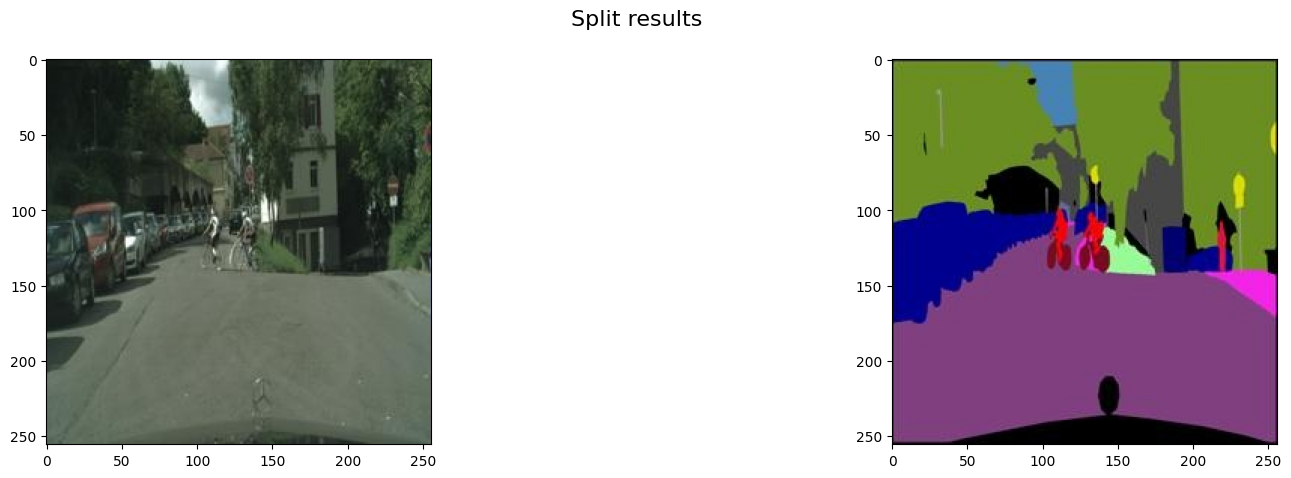

In [ ]:
# split function
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:,:256,:], image[:,256:,]
  return cityscape, label

cityscape, label = split_image(Image.open(os.path.join(train_dir, train_samples[0])))

# axes is the object for fig list, instead of fig.add_subplot(1,2,img_count)
# we use axes[0], axes[1] here to access imshow
fig, axes = plt.subplots(1,2,figsize = (20,5))
fig.suptitle('Split results', fontsize = (16))

# Image.fromarray(img) converts the numpy array to PIL Image format "<class 'PIL.Image.Image'>""
axes[0].imshow(Image.fromarray(cityscape))
axes[1].imshow(Image.fromarray(label))

plt.show()

In [ ]:
num_classes = 10
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
# label model using KMeans
label_model = KMeans(n_clusters= num_classes, n_init=10)
label_model.fit(color_array)

KMeans(n_clusters=10, n_init=10)

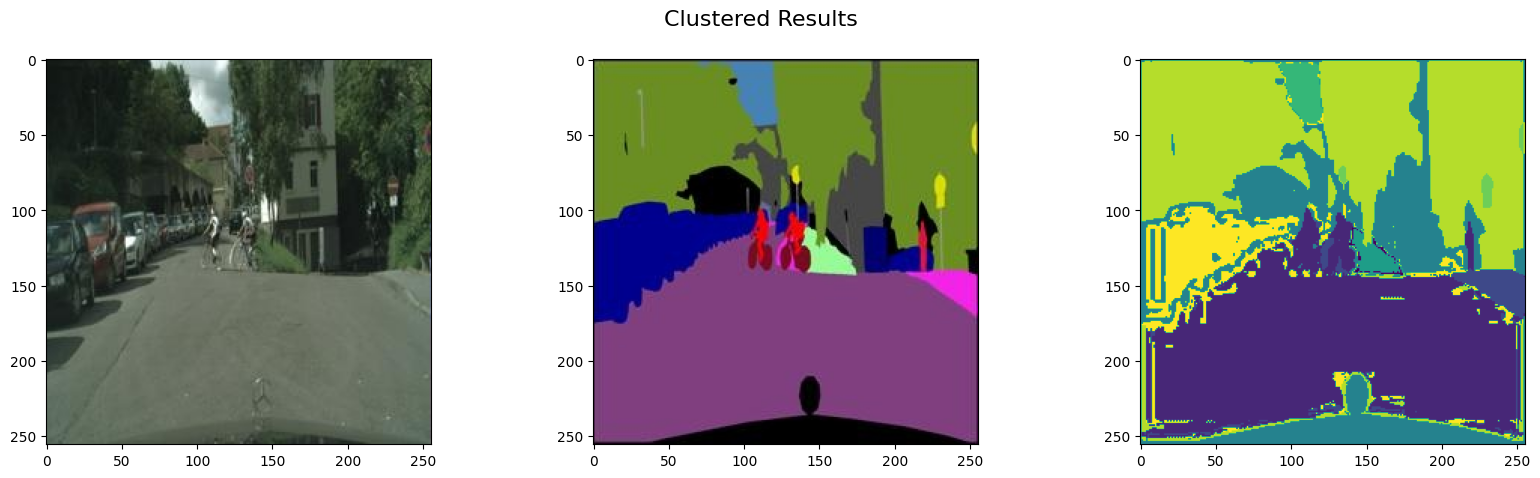

In [ ]:
cityscape, label = split_image(Image.open(os.path.join(train_dir, train_samples[0])))
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)

# axes is the object for fig list, instead of fig.add_subplot(1,2,img_count)
# we use axes[0], axes[1] here to access imshow
fig, axes = plt.subplots(1,3,figsize = (20,5))
fig.suptitle('Clustered Results', fontsize = (16))

# Image.fromarray(img) converts the numpy array to PIL Image format "<class 'PIL.Image.Image'>""
axes[0].imshow(Image.fromarray(cityscape))
axes[1].imshow(Image.fromarray(label))
axes[2].imshow(label_class)

plt.show()

In [ ]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  # double underscore on both side helps it to be callable with the len function of Dataset abstract class
  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert('RGB')
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    cityscape = self.transform(cityscape)
    label_class = torch.Tensor(label_class).long()
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:,:256,:], image[:,256:,]
    return cityscape, label

  def transform(self, image):
    transform_ops = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean = (0.485, 0.456, 0.406),
                                                             std = (0.229,0.224,0.225))])
    return transform_ops(image)


In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
print(f'Length of the dataset {len(dataset)}')

# sample representation of dataset
cityscape, label_class = dataset[0]
print(f'Shape of input and output label {cityscape.shape, label_class.shape}')

Length of the dataset 2975
Shape of input and output label (torch.Size([3, 256, 256]), torch.Size([256, 256]))


In [ ]:
device = torch.device('cuda')

In [ ]:
# Batch size of the training
batch_size = 16

data_loader = DataLoader(dataset, batch_size = batch_size)
print(f'Length of dataloader {len(data_loader)}')

data_iter = iter(data_loader)
x, y = next(data_iter)
x, y = x.to(device), y.to(device)
print(f'Input, Label shape of the dataloader {x.shape, y.shape}')

Length of dataloader 186
Input, Label shape of the dataloader (torch.Size([16, 3, 256, 256]), torch.Size([16, 256, 256]))


In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        se = self.global_avg_pool(x).view(b, c)
        se = self.fc1(se)
        se = self.relu(se)
        se = self.fc2(se)
        se = self.sigmoid(se).view(b, c, 1, 1)
        return x * se

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        super(ResidualBlock, self).__init__()
        self.conv1 = DepthwiseSeparableConv(in_channels, out_channels, stride)
        self.conv2 = DepthwiseSeparableConv(out_channels, out_channels, stride=1)
        self.se = SEBlock(out_channels, reduction)  # Squeeze-and-Excitation block
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.se(out)  # Apply SE block

        out = out + identity
        out = F.relu(out)  # Non-inplace ReLU to avoid issues
        return out



In [ ]:
class ResNet26_SE(nn.Module):  # DS = Depthwise Separable
    def __init__(self, num_classes=19):
        super(ResNet26_SE, self).__init__()
        self.in_channels = 64

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks (Encoder)
        self.layer1 = self._make_layer(64, 3)  # 3 blocks
        self.layer2 = self._make_layer(128, 4, stride=2)  # 4 blocks
        self.layer3 = self._make_layer(256, 6, stride=2)  # 6 blocks
        self.layer4 = self._make_layer(512, 3, stride=2)  # 3 blocks

        # Decoder: Upsampling layers
        self.upconv4 = self._upsample_block(512, 256)
        self.upconv3 = self._upsample_block(256, 128)
        self.upconv2 = self._upsample_block(128, 64)
        self.upconv1 = self._upsample_block(64, 64)

        # Final segmentation head
        self.seg_head = nn.Conv2d(64, num_classes, kernel_size=1)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        x1 = self.relu(self.bn1(self.conv1(x)))  # Initial convolution
        x1 = self.maxpool(x1)

        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)

        # Decoder
        d4 = self.upconv4(x5) + x4
        d3 = self.upconv3(d4) + x3
        d2 = self.upconv2(d3) + x2
        d1 = self.upconv1(d2)

        # Segmentation head
        out = self.seg_head(d1)

        # Resize output to match input resolution
        out = F.interpolate(out, size=x.size()[2:], mode='bilinear', align_corners=False)
        return out


In [ ]:
num_epochs = 25
device = 'cuda'
lr = 1e-03

criterion = nn.CrossEntropyLoss()

model = ResNet26_SE(num_classes=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [ ]:
def compute_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            total += y.numel()  # Count all pixels
            correct += (predicted == y).sum().item()
    return correct / total


In [ ]:
torch.autograd.set_detect_anomaly(True)
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (cityscapes, labels) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # Move data to device
        cityscapes, labels = cityscapes.to(device), labels.to(device)

        # Forward pass
        outputs = model(cityscapes)
        outputs = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)  # Adjust shape for CrossEntropyLoss
        labels = labels.view(-1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Compute average training loss
    avg_train_loss = running_loss / len(data_loader)
    train_loss_history.append(avg_train_loss)

    # Evaluate on validation set (if available)
    if val_dir:
        val_dataset = CityscapeDataset(val_dir, label_model)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for cityscapes, labels in val_loader:
                cityscapes, labels = cityscapes.to(device), labels.to(device)
                outputs = model(cityscapes)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Compute validation accuracy
        val_accuracy = compute_accuracy(val_loader, model)
        print(f"Validation Accuracy: {val_accuracy:.4%}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")




Epoch 1/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [1/25], Train Loss: 0.9396, Val Loss: 0.8498
Validation Accuracy: 71.2420%


Epoch 2/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [2/25], Train Loss: 0.6491, Val Loss: 0.7345
Validation Accuracy: 76.0762%


Epoch 3/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [3/25], Train Loss: 0.5750, Val Loss: 0.6114
Validation Accuracy: 79.9002%


Epoch 4/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [4/25], Train Loss: 0.5344, Val Loss: 0.5822
Validation Accuracy: 80.4347%


Epoch 5/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [5/25], Train Loss: 0.5011, Val Loss: 0.5921
Validation Accuracy: 80.6171%


Epoch 6/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [6/25], Train Loss: 0.4757, Val Loss: 0.5841
Validation Accuracy: 81.1169%


Epoch 7/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [7/25], Train Loss: 0.4524, Val Loss: 0.6328
Validation Accuracy: 79.8767%


Epoch 8/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [8/25], Train Loss: 0.4255, Val Loss: 0.6165
Validation Accuracy: 80.4849%


Epoch 9/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [9/25], Train Loss: 0.4008, Val Loss: 0.5947
Validation Accuracy: 81.2845%


Epoch 10/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [10/25], Train Loss: 0.3816, Val Loss: 0.6144
Validation Accuracy: 80.6548%


Epoch 11/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [11/25], Train Loss: 0.3636, Val Loss: 0.7161
Validation Accuracy: 78.3260%


Epoch 12/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [12/25], Train Loss: 0.3472, Val Loss: 0.7393
Validation Accuracy: 78.2326%


Epoch 13/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [13/25], Train Loss: 0.3351, Val Loss: 0.7023
Validation Accuracy: 79.3676%


Epoch 14/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [14/25], Train Loss: 0.3223, Val Loss: 0.6601
Validation Accuracy: 80.7431%


Epoch 15/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [15/25], Train Loss: 0.3143, Val Loss: 0.6295
Validation Accuracy: 81.6592%


Epoch 16/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [16/25], Train Loss: 0.3069, Val Loss: 0.6311
Validation Accuracy: 81.5762%


Epoch 17/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [17/25], Train Loss: 0.3005, Val Loss: 0.6472
Validation Accuracy: 81.8888%


Epoch 18/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [18/25], Train Loss: 0.2926, Val Loss: 0.6222
Validation Accuracy: 81.9412%


Epoch 19/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [19/25], Train Loss: 0.2862, Val Loss: 0.8230
Validation Accuracy: 75.6210%


Epoch 20/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [20/25], Train Loss: 0.2824, Val Loss: 0.7543
Validation Accuracy: 78.6695%


Epoch 21/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [21/25], Train Loss: 0.2774, Val Loss: 0.6997
Validation Accuracy: 80.1062%


Epoch 22/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [22/25], Train Loss: 0.2808, Val Loss: 0.6565
Validation Accuracy: 80.9765%


Epoch 23/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [23/25], Train Loss: 0.2761, Val Loss: 0.6895
Validation Accuracy: 80.4269%


Epoch 24/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [24/25], Train Loss: 0.2661, Val Loss: 0.6921
Validation Accuracy: 80.8624%


Epoch 25/25:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [25/25], Train Loss: 0.2588, Val Loss: 0.7706
Validation Accuracy: 79.6809%


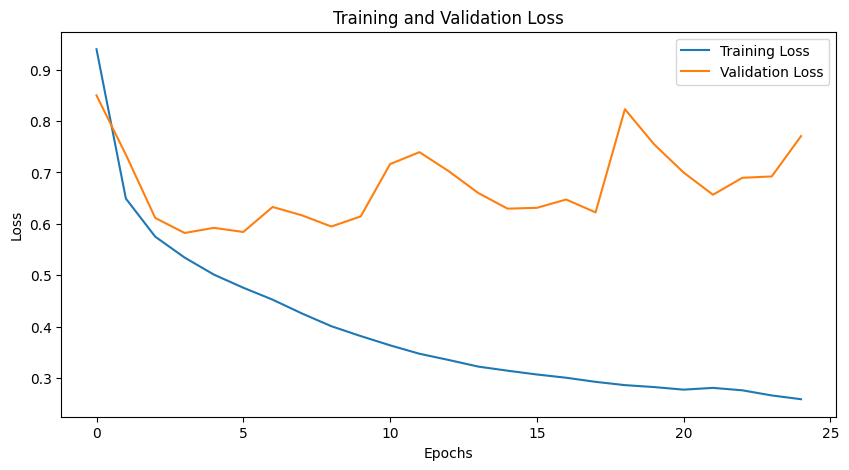

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Training Loss")
if val_dir:
    plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, logits, true, eps=1e-7):

        num_classes = logits.shape[1]
        if num_classes == 1:
            true_1_hot = torch.eye(num_classes + 1, device=true.device)[true.squeeze(1)]
            true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
            true_1_hot_f = true_1_hot[:, 0:1, :, :]
            true_1_hot_s = true_1_hot[:, 1:2, :, :]
            true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
            pos_prob = torch.sigmoid(logits)
            neg_prob = 1 - pos_prob
            probas = torch.cat([pos_prob, neg_prob], dim=1)
        else:
            true_1_hot = torch.eye(num_classes, device=true.device)[true.squeeze(1)]
            true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
            probas = F.softmax(logits, dim=1)
        true_1_hot = true_1_hot.type(logits.type())
        dims = (0,) + tuple(range(2, true.ndimension()))
        intersection = torch.sum(probas * true_1_hot, dims)
        cardinality = torch.sum(probas + true_1_hot, dims)
        union = cardinality - intersection
        iou = (intersection / (union + eps)).mean()
        return iou


iou_metrics = IoU()

In [ ]:
test_iou_score = 0.0

with torch.no_grad():
    for i, data in enumerate(val_loader):

        image_tiles, mask_tiles = data

        image = image_tiles.to(device)
        mask = mask_tiles.to(device)

        output = model(image)

        # IoU evaluation
        test_iou = iou_metrics(output, mask)
        test_iou_score += test_iou.item()


        im = image[0].cpu().numpy()
        im = np.moveaxis(im, 0, -1)
        ma = mask[0].cpu().numpy()
        #ma = np.argmax(ma, axis=0)

        out = output[0].cpu().numpy()
        out = np.argmax(out, axis=0)
        plt.figure(figsize=(16,9))
        plt.subplot(131)
        plt.title("Image")
        plt.imshow(im)
        plt.subplot(132)
        plt.title("Ground Truth")
        plt.imshow(ma)
        plt.subplot(133)
        plt.title("Output")
        plt.imshow(out, clim=[0, 7])
        plt.show()

        print(f"Test IoU = {test_iou}")


mean_test_iou_score = test_iou_score / len(val_loader)
print(f"Mean Test IoU = {mean_test_iou_score}")

Output hidden; open in https://colab.research.google.com to view.

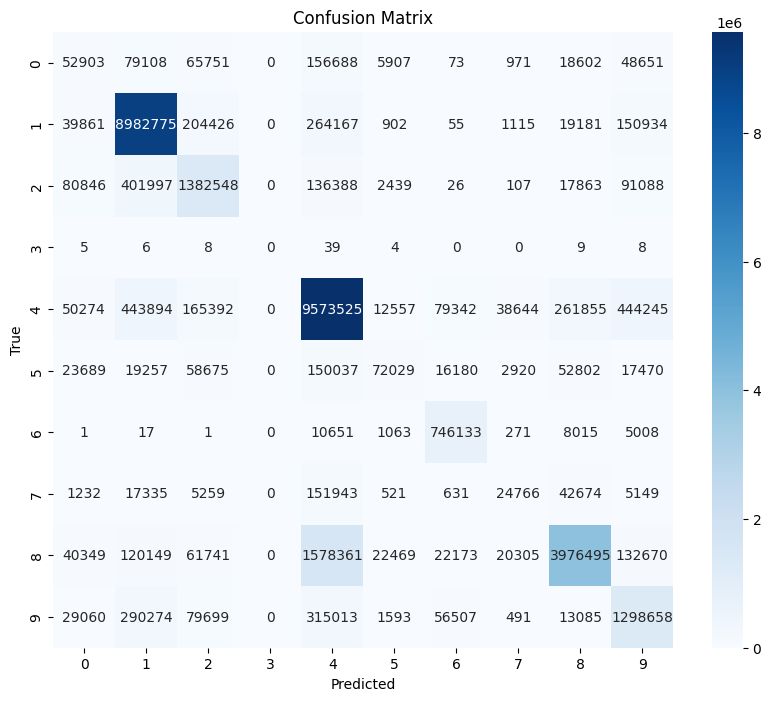

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, class_names):
    cm = cm.astype('int')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



num_classes = 10
class_names = [str(i) for i in range(num_classes)]
conf_matrix = np.zeros((num_classes, num_classes))

with torch.no_grad():
    for i, data in enumerate(val_loader):

        image_tiles, mask_tiles = data

        image = image_tiles.to(device)
        mask = mask_tiles.to(device)

        output = model(image)


        preds = torch.argmax(output, 1).cpu().numpy().flatten()
        targets = mask.cpu().numpy().flatten()
        conf_matrix += confusion_matrix(targets, preds, labels=list(range(num_classes)))

        im = image[0].cpu().numpy()
        im = np.moveaxis(im, 0, -1)
        ma = mask[0].cpu().numpy()
        # ma = np.argmax(ma, axis=0)

        out = output[0].cpu().numpy()
        out = np.argmax(out, axis=0)

plot_confusion_matrix(conf_matrix, class_names)

In [ ]:
model_name = 'Resnet26_SE.pth'
torch.save(model.state_dict(), model_name)

# Profiling

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity
import time

# Profiling function
def profile_model(model, data_loader, num_batches=10):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    # Wrap the profiling process
    with profile(
        activities=[
            ProfilerActivity.CPU,
            ProfilerActivity.CUDA
        ],
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./logs'),  # Logs to TensorBoard
        record_shapes=True,
        with_stack=True
    ) as prof:
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            if batch_idx >= num_batches:
                break
            inputs, targets = inputs.to(device), targets.to(device)

            # Measure throughput
            start_time = time.time()
            with record_function("model_inference"):
                outputs = model(inputs)
            latency = time.time() - start_time

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    print(f"\nLatency per batch: {latency:.4f} seconds")
    print(f"Throughput: {len(inputs) / latency:.4f} samples/second")

    # Display additional metrics
    print(f"Peak GPU memory usage: {torch.cuda.max_memory_allocated(device) / (1024 * 1024):.2f} MB")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameter count: {total_params}")
    print(f"FLOPs estimation: {total_params * 2:.2e} FLOPs (assuming 2 operations per parameter)")

# Run profiling
profile_model(model, data_loader)



-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us        4.138s       973.43%        4.138s     413.843ms            10  
                                        model_inference         3.38%     194.259ms        72.51%        4.167s     416.727ms       0.000us         0.00%     380.506ms      38.051ms            10  
         